In [1]:
from IPython.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from desdeo_emo.EAs import RVEA, NSGAIII
from desdeo_problem.testproblems.TestProblems import test_problem_builder
from desdeo_problem import DataProblem
from desdeo_tools.utilities import fast_non_dominated_sort, hypervolume_indicator

import matplotlib.pyplot as plt
import sklearn
from pyDOE import lhs
import pandas as pd

## Assignment 3


## Task 1 

 Use EI and the mean prediction to solve any single objective benchmark problem (e.g.
Ackley, Rosenblock, sphere etc.) with any single objective optimizer (preferably GA). 

Set max exact function evaluations to 50 (start with 50 design points). Was the solutions
found by EI better? (you can implement EI is you wish to)

In [57]:
# Problem is the expensive function to evaluate.
# use ackley


# prob takes now all as vectors, need to change GA to do so too.
def problem(x):
    # if only one solution to calculate
    if x.shape[0] == 2:
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
        term2 = np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1])))
    else:
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[:,0]**2 + x[:,1]**2)))
        term2 = np.exp(0.5 * (np.cos(2 * np.pi * x[:,0]) + np.cos(2 * np.pi * x[:,1])))
    return term1 - term2 + np.exp(1) + 20


In [58]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor


def surrogate(model, x):
    return model.predict(x, return_std=True)

def posteori_mean_pred(x, model):
    return model.predict(x)
    
def opt_acq(x, y, model):
    x_samples = create_samples(2, 50, bounds)
    
    scores = posteori_mean_pred(x_, model)
    best_x = np.argmin(scores)
    
    sampled_scores = posteori_mean_pred(x_samples, model)
    best_sampled = np.argmin(sampled_scores)
    
    if x[best_x] < x_samples[best_sampled]:
        return best_x
    else:
        return best_sampled

mean_pred_result_all = []
times = 10
bounds = np.array([[-2, -2], [2, 2]])

for _ in range(times):
       
    x = create_samples(2, pop_s, bounds)
    y = problem(x)
    kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
    model = GaussianProcessRegressor(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y)
    
    fmax = 0           
    while fmax < 50:
        best_x = np.argmin(posteori_mean_pred(x, model))
        best_x = x[best_x]
        
        true_y = problem(best_x) # + 1 fmax..
        fmax += 1
    
        x = np.vstack((x, [best_x]))
        y = np.hstack((y, [true_y]))

        # update surr
        model.fit(x, y)
            
  
    print("==============================")
    fit = np.min(y)
    print("best y", fit)
    print("best x", x[np.argmin(y)])

    mean_pred_result_all.append(fit)

best y 0.4281779253080735
best x [0.08435973 0.01610936]
best y 0.62693039016958
best x [0.06584527 0.09103724]
best y 1.4904314559187704
best x [0.18512376 0.10272896]
best y 1.9103501789138235
best x [0.23239563 0.11716722]
best y 0.5467583067962849
best x [0.02770386 0.09850377]
best y 1.141740712851412
best x [0.16466865 0.0565717 ]
best y 0.3625119133385546
best x [0.01974848 0.07346738]
best y 0.7330416834460713
best x [0.1165567  0.04776661]
best y 1.3406148199575405
best x [0.19743276 0.02018924]
best y 0.20230340956763726
best x [0.04149079 0.02635573]


In [59]:
mean_pred_result_all

[0.4281779253080735,
 0.62693039016958,
 1.4904314559187704,
 1.9103501789138235,
 0.5467583067962849,
 1.141740712851412,
 0.3625119133385546,
 0.7330416834460713,
 1.3406148199575405,
 0.20230340956763726]

In [60]:
np.mean(mean_pred_result_all)

0.8782860796267749

In [61]:
def create_samples(dec_dim, samples, bounds):
    # create samples 
    x = lhs(dec_dim, samples)    
    # scale
    #lower = bounds[0]
    #upper = bounds[1]
    #x = x * (upper - lower) + lower    
    return np.asarray(x)

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, RationalQuadratic, DotProduct, ConstantKernel, Matern

class real_GA:
    def __init__(self, problem, pop, pop_size, pm, bounds, di, order, fitness=None, max_func_evals=50, gen_max=50):
        self.problem = problem # problem function to solve
        self.pop = pop # pop array to hold binary population strings
        self.pm = pm # probability of mutation
        self.pop_size = pop_size # population size
        self.lbounds = bounds[0]
        self.ubounds = bounds[1]
        self.di = di # for crossover
        self.order = order # for mutation
        self.gen_max = gen_max # max generations
        self.max_func_evals = max_func_evals
        
        self.fitness = fitness # fitness array to hold calculated fitness values
        self.gen = 0 # current generation
        
    # start pop and evaluate each member in the pop
    def initialize(self):
        if len(self.pop) < 1:
            x1range = np.random.uniform(low=self.lbounds[0], high=self.ubounds[0], size=self.pop_size)
            x2range = np.random.uniform(low=self.lbounds[1], high=self.ubounds[1], size=self.pop_size)
            self.pop = np.stack((x1range, x2range), axis=-1)

        #self.pop_size = self.pop.shape[0]
        self.fitness = self.evaluate(x)


    # run the GA for one iteration
    def run(self):
        n = 0 # init iterations
        self.initialize()

        next_gen = [] # init next_gen population array
        for i in range(int(self.pop.shape[0]/2)):
            # select two individuals with deterministic tournament selection, append them in a next gen list for crossover
            i1, i2 = self.tour_select()
            s1 = self.pop[i1]
            s2 = self.pop[i2]
            next_gen.append(s1)
            next_gen.append(s2)
            
        # crossover. Happens every time
        next_gen = self.SBX(next_gen)
            
        # Mutation. happens if rand < pm for member in pop
        for i in range(self.pop_size):
            if np.random.rand() < self.pm:
                next_gen[i] = self.poly_mutation(next_gen[i], self.order)
         
        self.pop = np.asarray(next_gen) # add next gen to self pop               
        self.fitness = self.evaluate(x)
        
        n += 1
        self.gen += 1     
    
    # evaluate population members
    def evaluate(self, x):
        return problem(x)
        
        
    # deterministic binary tournament selection
    def tour_select(self):        
        cf = self.fitness
        b1 = np.argmin(cf) # get best member by fitness
        cf = np.delete(cf, b1) # remove it from cf
        b2 = np.argmin(cf) # get (2nd) best member by fitness
        return b1, b2 # return best and 2nd best members as parents
        
        
    # Simulated binary crossover (non-bounded)
    def SBX(self, parents):
        parents = np.asarray(parents)
        pop_size, num_var = parents.shape
        children = np.zeros_like(parents)
        for i in range(0, pop_size, num_var):
            p1 = (parents[i] + parents[i + 1]) / 2
            p2 = (parents[i] - parents[i + 1]) / 2
            beta = np.zeros(num_var)
            alpha = np.random.rand(num_var)
            bx = np.random.randint(0, high=2, size=num_var)
            beta[alpha <= 0.5] = (2 * alpha[alpha <= 0.5])**(1 / (self.di + 1))
            beta[alpha > 0.5] = (2 - 2 * alpha[alpha > 0.5])**(-1 / (self.di + 1))            
            beta = beta * ((-1)**bx)
            children[i] = p1 + beta * p2
            children[i + 1] = p1 - beta * p2
        return children
        
    
    # polynomial mutation for one pop member p
    def poly_mutation(self, p, order):
        children = np.array([0,0])
        for i in range(0, 2):
            pL = self.lbounds[i]
            pU = self.ubounds[i]
            u = np.random.random() # r [0,1]
            mp = 0
            dl = (2*u)**(1/1+order) - 1
            dr = 1 - (2*(1 - u))**(1/1+order) 
            if u <= 0.5:
                mp = p[i] + dl*(p[i] - pL)
            else:
                mp = p[i] + dr*(pU - p[i])
            children[i] = mp
        return children

### Using mean pred

### using EI

In [76]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor

EI_result_all = []

def surrogate(model, x):
    return model.predict(x, return_std=True)

from scipy.stats import norm
from scipy.special import ndtr

def EI(mean, std, max_val, tradeoff):
    imp = (mean - max_val - tradeoff)
    z = imp / std
    ei = imp * norm.cdf(z) + std * norm.pdf(z)
    ei[std == 0.0] = 0.0
    return ei
    

def expected_impr(x0, x_sample, y, model):
    mu, sigma = model.predict(x0, return_std=True)
    sigma = sigma.reshape(-1, 1)
    max_val = np.max(y)
    tradeoff = 0.01

    return EI(mu, sigma, max_val, tradeoff)


from scipy.optimize import minimize

def propose_location(X_sample, Y_sample, model, bounds):
    min_x = np.array([1.,1.]) # atleast return something
    
    def min_obj(X0):
        # Minimization objective is the negative acquisition function
        return -expected_impr(X0, X_sample, Y_sample, model)
    
    # Find the best optimum by starting from n_restart different random points.   
    
    # use GA here
    # params
    pop_s = Y_sample.shape[0]
    pm = 0.1
    bounds = np.array([[-2, -2], [2, 2]]) # variable bounds (lower, upper)
    gen_max = 50
    di = 2 # distribution index
    order = 20 # polynomial order param

    pop = create_samples(2, pop_s, bounds)
    ga = real_GA(min_obj, pop, pop_s, pm, bounds, di, order, fmax, gen_max)
    for _ in range(20):
        ga.run()
    
    best_fit = np.argmin(ga.fitness)
    min_x = ga.pop[best_fit]
    
    
    #for x0 in np.random.uniform(-2, 2, size=(n_restarts, dim)):
    #    res = minimize(min_obj, x0=x0, bounds=((-2.1,2.1),(-2.1, 2.1)), method='L-BFGS-B')
    #    if res.fun < min_val:
    #        min_val = res.fun
    #        min_x = res.x 
            
            
    return min_x

EI_result_all = []
times = 10

for _ in range(times):
    x = create_samples(2, pop_s, bounds)
    y = problem(x)
    kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
    
    model = GaussianProcessRegressor(kernel,n_restarts_optimizer=1,random_state=7).fit(x, y)
    
    fmax = 0
    while fmax < 50:

        best_x = propose_location(x, y, model, bounds)
        #print(best_x)
        true_y = problem(best_x) # + 1 fmax..
        fmax += 1
        
        # add to data. have to keep x, y == pop.size to not break GA currently.
        worst_y = np.argmax(y)
        x = np.delete(x, worst_y, axis=0)
        y = np.delete(y, worst_y, axis=0)
        x = np.vstack((x, best_x))
        y = np.hstack((y, true_y))

        # update surr
        model.fit(x, y)
    
    print("==============================")
    fit = np.min(y)
    print("best y", fit)
    print("best x", x[np.argmin(y)])

    EI_result_all.append(fit)

[0.67023164 0.60619524] 12
[0.68152567 0.74461504] 28
[0.61063542 0.65023868] 10
[ 0.72898609 -0.53895234] 48
[-1.97019939  0.8257351 ] 49
[ 3.45092693 -0.90810673] 49
[1.7656478  2.71008483] 49
[0.79254851 1.15006585] 49
[0.7914323  0.48574688] 26
[0.45340023 0.92143006] 0
[3.74277553 0.74685675] 49
[-3.68752444  1.42510064] 49
[-0.36242     3.19739501] 49
[-0.67357562  1.57985182] 49
[ 1.71085502 -0.59110998] 49
[1.67851013 0.92884768] 49
[0.92716547 0.68173354] 25
[0.84617719 0.71609122] 15
[-1.2728929  -7.43846493] 49
[-2.51125108 -1.06440265] 49
[-0.79669581 -2.11097894] 49
[-1.37822567 -1.0740427 ] 49
[-1.05874645 -0.42419576] 49
[0.52966196 0.57758068] 21
[ 0. -2.] 49
[-1.15169934 -2.42854449] 49
[-3.52145328  1.06713751] 49
[ 1.61965445 -1.59195796] 49
[ 1.12609313 -1.98340655] 49
[1.0844699  3.20066696] 49
[0.43999823 0.87969405] 47
[ 0.11724242 -1.32106634] 49
[-1.73605341 -1.79838254] 49
[0.43125443 0.89302523] 11
[1.38330332 0.83490781] 49
[3.33919496 8.9026597 ] 49
[-1.945

KeyboardInterrupt: 

In [73]:
EI_result_all

[0.20436476095542488,
 0.1716942983327705,
 0.3219505051408227,
 0.7089939723077059,
 0.8614308748725996,
 0.2922008185695866,
 0.9194645918099091,
 1.348610634540691,
 0.5914415336367718,
 0.87823800290289]

In [74]:
np.mean(EI_result_all)

0.6298389993069172

In [66]:
problem(np.array([0.11880519, 0.10706982]))

1.0313415153941499

## Results:

koko GA taitaa nyt jäädä käyttämättä. Ilmeisesti sillä pitäisi optimoida tuota EI mutta kun ei osaa niin ei osaa. menköön scipy minimizellä sitten. posteriorissa sitä ei vissin edes tarvitse.

#### Botorch stuff

## Task 2

Solve any benchmark problems (K=2 and 5, n=10) with ParEGO and LCB.
Start with 109 design points. Compare the hypervolume of the solutions after 100 exact function
evaluations.

#### Notes

$$
LCB(x) = \mu(x) - \beta \sigma (x)
$$

β is a parameter controlling the
degree of exploration


Maybe try Botorch? now reason to try the framework!

https://botorch.org/tutorials/multi_objective_bo

has example here how to use parEGo

https://github.com/shinya-ml/Multiobj-Bayes-opt

Basically, MOPGI, custom class wrapper for Gpy's GPR to handle multiple outputs. Has also predict method using NSGA-II as the optimizer. Query dataset.get_observed seems to be the part where calls the optim.

Then max iter loop for ParEGO, optim, fit using MOPGI, until done.

##### steps

- LHS? to generate 109 design points
- LCB and ParEGO are acquisition fucntions.. Use NSGA-III or whatever as the optimizer.


ParEGO

1. Draw random weight vector λ
2. Scalarize the objectives (using ASF) for the
provided data
3. Build GP on the scalarized objectives
4. Maximize EI
5. Evaluate and Repeat from step 1

-- use LCB first, simpler.

In [ ]:
# https://github.com/yunshengtian/DGEMO/blob/master/mobo/mobo.py

# idea how Multiobjective bayesian optimization goes

# if nothing else use this repo bc it should be able to do the things

In [20]:
def LCB(mean, std, beta=.5):
    return mean - beta*std

In [4]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

/home/jp/kurssit/data-driven/assignments/38datademos_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [159]:
from botorch.test_functions import DTLZ2

#problem = DTLZ2(dim=10, num_objectives=2, negate=True) # chekc if need to negate
problem = DTLZ2(dim=10, num_objectives=2)


In [160]:
problem.ref_point = torch.tensor([0.0,0.0])

In [161]:
problem.ref_point

tensor([0., 0.])

In [162]:
problem.bounds

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [163]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

NOISE_SE = torch.tensor([1., 1.])

BATCH_SIZE = 4
NUM_RESTARTS = 5 if not SMOKE_TEST else 2
RAW_SAMPLES = 64 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, problem.dim)
standard_bounds[1] = 1

def generate_initial_data(n=109):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds,n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    train_x = normalize(train_x, problem.bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i:i+1]
        train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        models.append(
            FixedNoiseGP(train_x, train_y, train_yvar, outcome_transform=Standardize(m=1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [164]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.utils.sampling import sample_simplex

def optimize_qucb_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qucb acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    with torch.no_grad():
        pred = model.posterior(normalize(train_x, problem.bounds)).mean

    weights = sample_simplex(problem.num_objectives).squeeze()
    objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=pred))
    acq_func = qUpperConfidenceBound(
        model=model,
        beta=0.5,
        sampler=sampler,
        objective=objective,
        #posteori_transform=,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 30},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    
    new_obj = new_obj_true #+ torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

In [165]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement


def optimize_qnparego_and_get_observation(model, train_x, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization 
    of the qNParEGO acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, problem.bounds)
    with torch.no_grad():
        pred = model.posterior(train_x).mean
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=pred))
        acq_func = qNoisyExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 30},
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    
    # Here happens function evaluation
    new_obj_true = problem(new_x)
    
    
    new_obj = new_obj_true # + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

In [167]:
from botorch import fit_gpytorch_model
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

import time
import warnings


warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

N_BATCH = 100 if not SMOKE_TEST else 10
MC_SAMPLES = 64 if not SMOKE_TEST else 16

verbose = True

hvs_qparego, hvs_qucb, = [], []

n = 109

# call helper functions to generate initial training data and initialize model
train_x_qparego, train_obj_qparego, train_obj_true_qparego = generate_initial_data(n=109)
mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)

train_x_qucb, train_obj_qucb, train_obj_true_qucb = train_x_qparego, train_obj_qparego, train_obj_true_qparego

mll_qucb, model_qucb = initialize_model(train_x_qucb, train_obj_qucb)

# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
volume = bd.compute_hypervolume().item()

hvs_qparego.append(volume)
hvs_qucb.append(volume)


# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):    
    
    t0 = time.time()
    
    # fit the models
    fit_gpytorch_model(mll_qparego)
    fit_gpytorch_model(mll_qucb)

    
    # define the qEI and qNEI acquisition modules using a QMC sampler
    qparego_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
    qucb_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)

    
    # optimize acquisition functions and get new observations
    new_x_qparego, new_obj_qparego, new_obj_true_qparego = optimize_qnparego_and_get_observation(
        model_qparego, train_x_qparego, train_obj_qparego, qparego_sampler
    )
    new_x_qucb, new_obj_qucb, new_obj_true_qucb = optimize_qucb_and_get_observation(
        model_qucb, train_x_qucb, train_obj_qucb, qucb_sampler
    )
            
    # update training points
    train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
    train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
    train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj_true_qparego])

    train_x_qucb = torch.cat([train_x_qucb, new_x_qucb])
    train_obj_qucb = torch.cat([train_obj_qucb, new_obj_qucb])
    train_obj_true_qucb = torch.cat([train_obj_true_qucb, new_obj_true_qucb])
    

    # update progress
    for hvs_list, train_obj in zip(
        (hvs_qparego, hvs_qucb), 
        ( train_obj_true_qparego, train_obj_true_qucb),
    ):
        # compute hypervolume
        bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
    mll_qucb, model_qucb = initialize_model(train_x_qucb, train_obj_qucb)

    #print(train_x_qucb[0,0])
    
    t1 = time.time()
    
    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (qNParEGO, qUCB) = "
            f"({hvs_qparego[-1]:>4.2f}, {hvs_qucb[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.", end=""
        )
    else:
        print(".", end="")


print("pref_point", problem.ref_point)
print("==========")
print(train_obj_true_qucb[:5])
print("==========\n")
print(train_obj_true_qparego[:5])


Batch  1: Hypervolume (qNParEGO, qUCB) = (3.45, 3.45), time = 3.23.
Batch  2: Hypervolume (qNParEGO, qUCB) = (3.45, 3.45), time = 2.27.
Batch  3: Hypervolume (qNParEGO, qUCB) = (3.45, 3.45), time = 2.53.
Batch  4: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 3.05.
Batch  5: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 2.91.
Batch  6: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 3.09.
Batch  7: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 2.61.
Batch  8: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 3.22.
Batch  9: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 3.10.
Batch 10: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 3.34.
Batch 11: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 3.71.
Batch 12: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 3.80.
Batch 13: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 5.00.
Batch 14: Hypervolume (qNParEGO, qUCB) = (3.45, 3.48), time = 5.22.
Batch 15: Hypervolume (qNParEGO, qUCB) = (3.46,

## BOtorch seems to do weird things..

seems like they assume maximization? or they convert reference point someway when using HV since worse point than solutions gives 0 hv

Also have to use UCB bc botorch does not have LCB (prob bc assume maximization). this adds to the confusion, but maybe thats why ref_point needs to be worse than members.

ValueError: 'x' and 'y' must have the same size

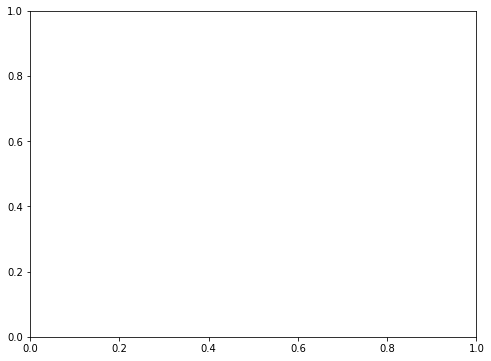

In [42]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(problem.max_hv - np.asarray(hvs_qparego))
log_hv_difference_qucb = np.log10(problem.max_hv - np.asarray(hvs_qucb))

log_hv_difference_rnd = np.log10(problem.max_hv - np.asarray(hvs_random))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters, log_hv_difference_rnd, label="Sobol", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qparego, label="qNParEGO", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qucb, label="qUCB", linewidth=1.5,
)

ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower left")

TypeError: from_bounds() missing 1 required positional argument: 'height'

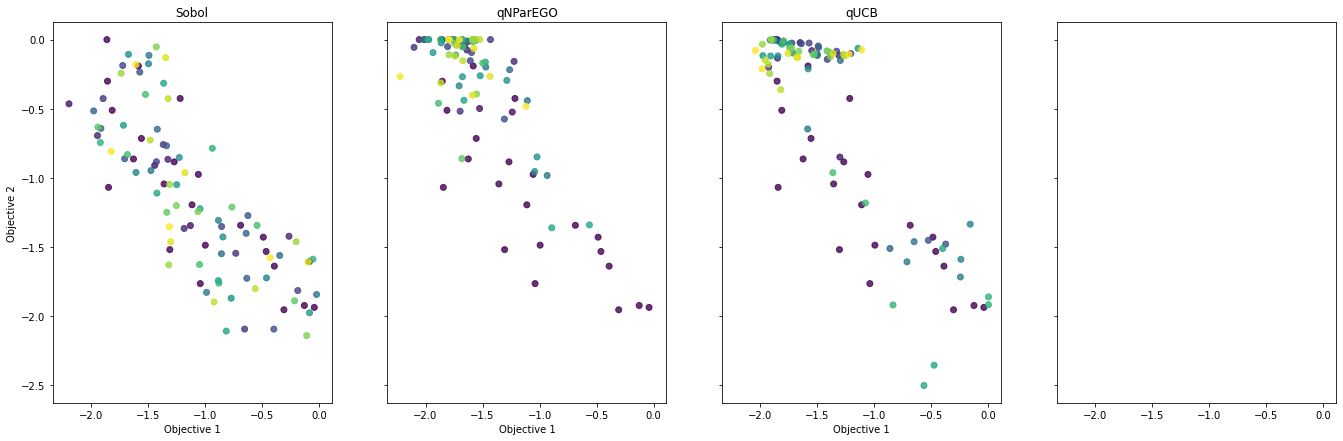

In [16]:
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(1, 4, figsize=(23, 7), sharex=True, sharey=True)
algos = ["Sobol", "qNParEGO", "qUCB"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(2*(problem.dim+1)), torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()
for i, train_obj in enumerate((train_obj_true_random, train_obj_true_qparego, train_obj_true_qucb)):
    sc = axes[i].scatter(
        train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), c=batch_number, alpha=0.8,
    )
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")